# Single nanocrystal reconstruction from coherent diffraction data: a study in undersampling reciprocal space

Siddharth Maddali

### Synchrotron Radiation Studies group

### Materials Science Division
### Argonne National Laboratory

## Modules

In [4]:
import numpy as np
from PIL import Image # PIL is used to handle multilayer TIF files.
import FastPhaseRetriever as pr # PhaseRetriever contains the solver 
import ImageProcessing as imgp # some auxiliary functions like support generation
import matplotlib.pyplot as plt # Plotting
from pyfftw.interfaces.numpy_fft import fftshift, fftn, ifftn # FFTW with the numpy interface
from mayavi import mlab # Mayavi for cool 3d visualizations
import dill # Dill, for pickling
from tqdm import tqdm
from joblib import Parallel, delayed
from IPython.display import HTML, display
import time

## Visualizations inside notebook...

In [5]:
# To generate plots inline
%matplotlib inline

# mayavi notebook mode
mlab.init_notebook( width=500, height=500 )

Notebook initialized with x3d backend.


# Pre-processing of data 
   - Load multi-layer TIFF file with Python's PIL library.

In [6]:
data = Image.open( 'Cha316c_S2412.tif' )

   - Ensure that the data box size is even in each dimension. 

In [7]:
M, N = data.size[0], data.size[1]
img = np.array( [] ).reshape( data.size[0], data.size[1], 0 )
for i in range( data.n_frames ):
    data.seek( i )
    img = np.concatenate( 
        ( 
            img, 
            np.array( data.getdata() ).reshape( M, N, 1 )
        ), 
        axis=2 
    )
img = img[ 
    ( img.shape[0]%2 ):, 
    ( img.shape[1]%2 ):, 
    ( img.shape[2]%2 ):
]

# Visualization of the modulus constraint for a single layer (`sqrt` of a detector image)

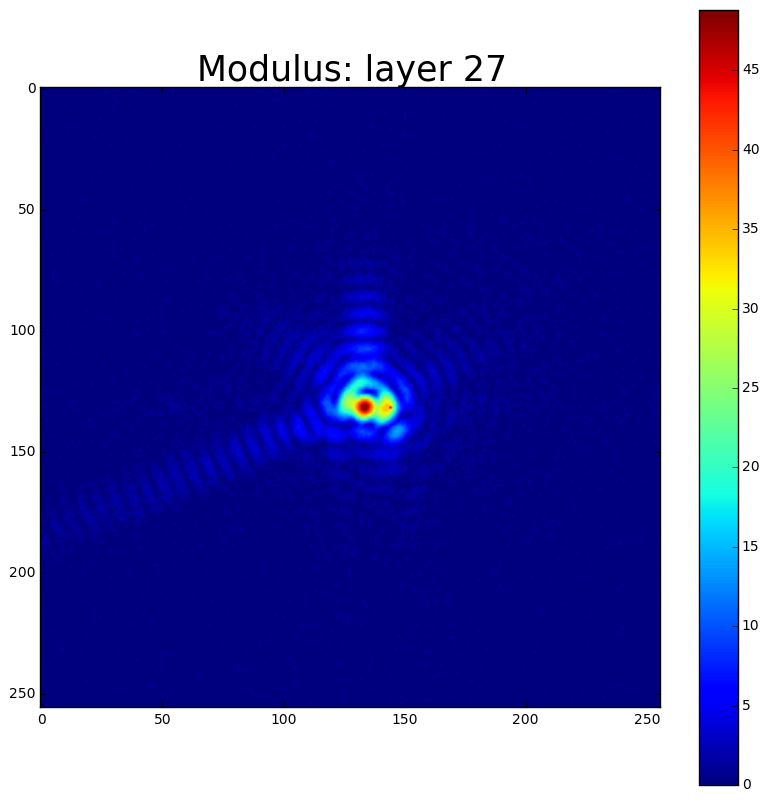

In [9]:
plt.figure( figsize=( 10, 10 ) );
plt.imshow( np.sqrt( img[:,:,27] ) );
plt.title( 'Modulus: layer 27', fontsize=25 );
plt.colorbar();

# Solvent flipping
   - Modulus constraint $\mathbf{P}$: set to measured value. 
       - Nonlinear operator, represented by a curve.
       - $\boldsymbol{\rho} \longrightarrow \mathbf{P} \boldsymbol{\rho}$

   - Support constaint $\mathbf{S}$: Set volume outside which no material exists.
       - Linear operator, represented by a plane.
       - $\boldsymbol{\rho} \longrightarrow \mathbf{S}\boldsymbol{\rho}$

   - Reflection constraint $\mathbf{R}_S$: Reflect in the plane represented by $\mathbf{S}$.
       - Linear operator.
       - $\boldsymbol{\rho} \longrightarrow \mathbf{R}_s \boldsymbol{\rho} = \left(2\mathbf{S} - \boldsymbol{1}\right)\boldsymbol{\rho}$

In [10]:
display( HTML("""
<table>
    <tr>
    <td><img src="images/SolventFlipping_1.png"></td>
    <td><img src="images/SolventFlipping_2.png"></td>
    </tr>
</table>
"""))

   - Alternate projection onto modulus constraint $\mathbf{P}$, and reflection $\tilde{\mathbf{P}}$ in the plane of $\mathbf{S}$.
   - Variants: converge at different rates w.r.t. iteration number.
   - Same amount of walltime (because $\tilde{\mathbf{P}}$ is nonlinear).

## Initial support generation

   - Initial ellipsoidal support.

   - Displace support by 2-3 pixels in each dimension.

- Support size guessed or estimated from knowledge of experimental geometry.

In [11]:
MySupp = imgp.GenerateSupport( img, [ 30, 30, 16 ], 'circ' )

# Visualization of initial support

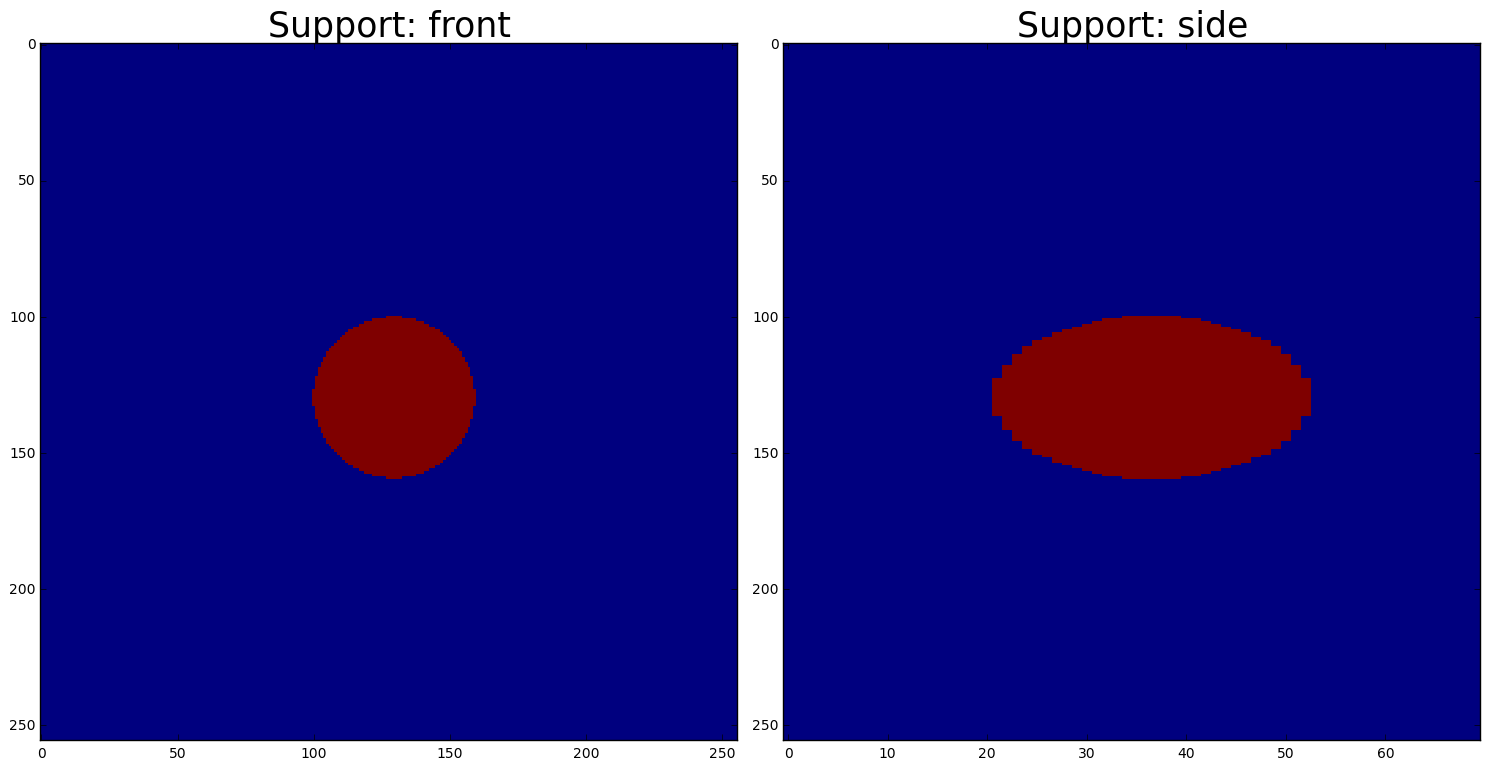

In [12]:
fig = plt.figure( figsize=( 15, 15 ) );
ax1 = plt.subplot2grid( ( 1, 2 ), ( 0, 0 ), colspan=1 );
im1 = ax1.imshow( MySupp[:,:,34], interpolation='none' );
ax1.set_title( 'Support: front', fontsize=25 );

ax2 = plt.subplot2grid( ( 1, 2 ), ( 0, 1 ), rowspan=1 );
im2 = ax2.imshow( MySupp[:,127,:], interpolation='none' );
ax2.set_title( 'Support: side', fontsize=25 );
ax2.set_aspect( 70./256.)
fig.tight_layout();

   - Solver `PhaseRet_BB` iscreated.

In [13]:
PhaseRet_BB = pr.PhaseRetriever( modulus=np.sqrt( img ), support=MySupp, beta=0.9 )

   - We now try a regimen of SF-HIO-SF.

In [14]:
PhaseRet_BB.SolventFlipping( 50 )
PhaseRet_BB.HybridIO( 30 )
PhaseRet_BB.SolventFlipping( 50 )

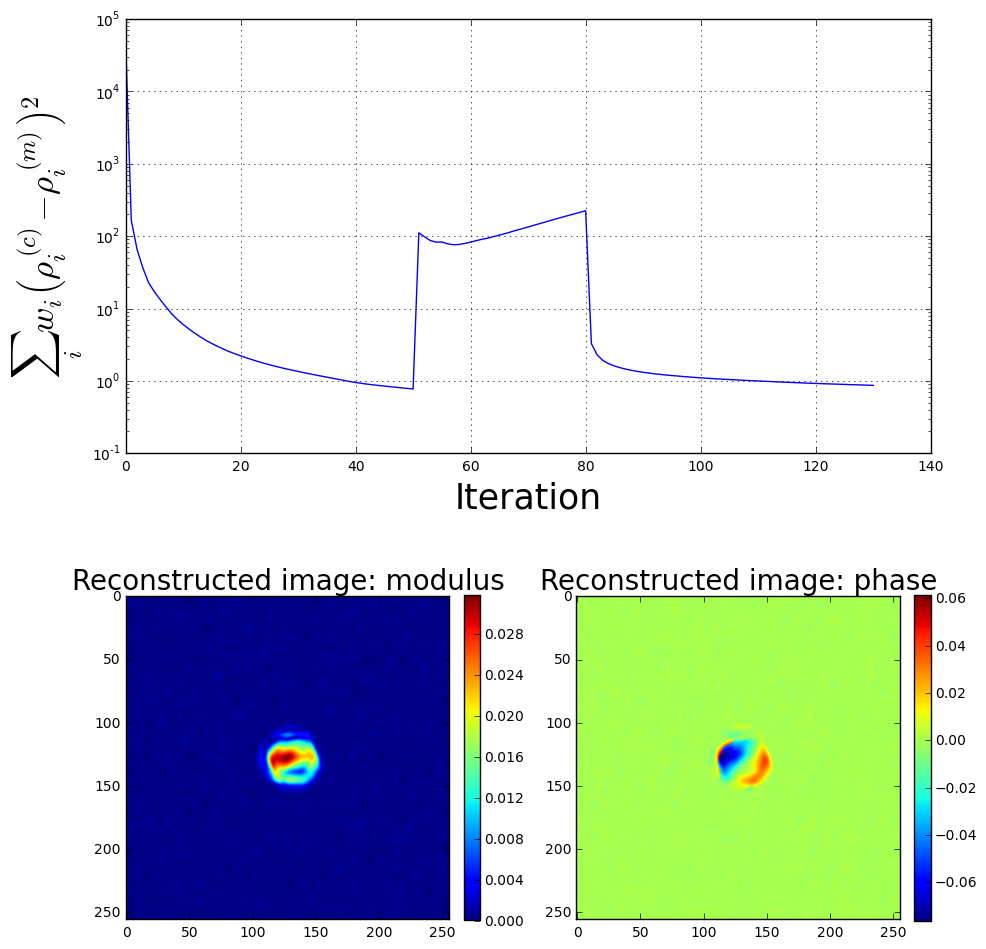

In [15]:
img_1 = PhaseRet_BB.Image()

fig = plt.figure( figsize=( 10, 10 ) )

# ax1 = fig.add_subplot( 131 )
ax1 = plt.subplot2grid( ( 2, 2 ), ( 0, 0 ), colspan=2 )
ax1.semilogy( PhaseRet_BB.Error(), '-' )
ax1.grid( 'on' )
ax1.set_xlabel( 'Iteration', fontsize=25 )
ax1.set_ylabel( 
    r'$\sum_i w_i\left(\rho_i^{(c)} - \rho_i^{(m)}\right)^2$', 
    fontsize=25 )

# ax2 = fig.add_subplot( 132 )
ax2 = plt.subplot2grid( ( 2, 2 ), ( 1, 0 ), colspan=1 )
im2 = ax2.imshow( np.absolute( img_1[:,:,35] ) )
ax2.set_title( 'Reconstructed image: modulus', fontsize=20 )

# ax3 = fig.add_subplot( 133 )
ax3 = plt.subplot2grid( ( 2, 2 ), ( 1, 1 ), colspan=1 )
im3 = ax3.imshow( np.angle( img_1[:,:,35] ) * np.absolute( img_1[:,:,35] ) )
ax3.set_title( 'Reconstructed image: phase', fontsize=20 )

fig.colorbar( im2, ax=ax2, fraction=0.046, pad=0.04 )
fig.colorbar( im3, ax=ax3, fraction=0.046, pad=0.04 )
fig.tight_layout()

   - Vaguely faceted strucure: promising
   - Update the support by shrinkwrap

In [16]:
MySupp2 = imgp.GaussianKernelSupport( 
    np.absolute( img_1 ), 
    sigma=[ 5., 5., 5. ], 
    threshold=0.15 )

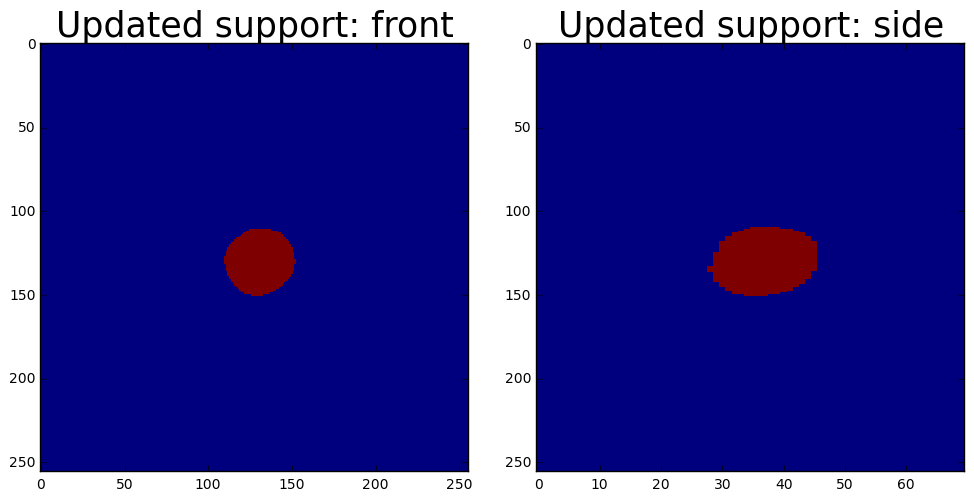

In [17]:
fig = plt.figure( figsize=( 10, 10 ) )

ax1 = plt.subplot2grid( ( 1, 2 ), ( 0, 0 ), colspan=1 )
im1 = ax1.imshow( MySupp2[:,:,34], interpolation='none' )
ax1.set_title( 'Updated support: front', fontsize=25 )

ax2 = plt.subplot2grid( ( 1, 2 ), ( 0, 1 ), colspan=1 )
im2 = ax2.imshow( MySupp2[:,127,:], interpolation='none' )
ax2.set_title( 'Updated support: side', fontsize=25 )
ax2.set_aspect( 70. / 256. )

fig.tight_layout()

   - Update support.
   - Solvent flipping (50 iterations)
   - Error reduction (50 iterations)

In [18]:
PhaseRet_BB.UpdateSupport( MySupp2 )
PhaseRet_BB.SolventFlipping( 50 )
PhaseRet_BB.ErrorReduction( 50 )

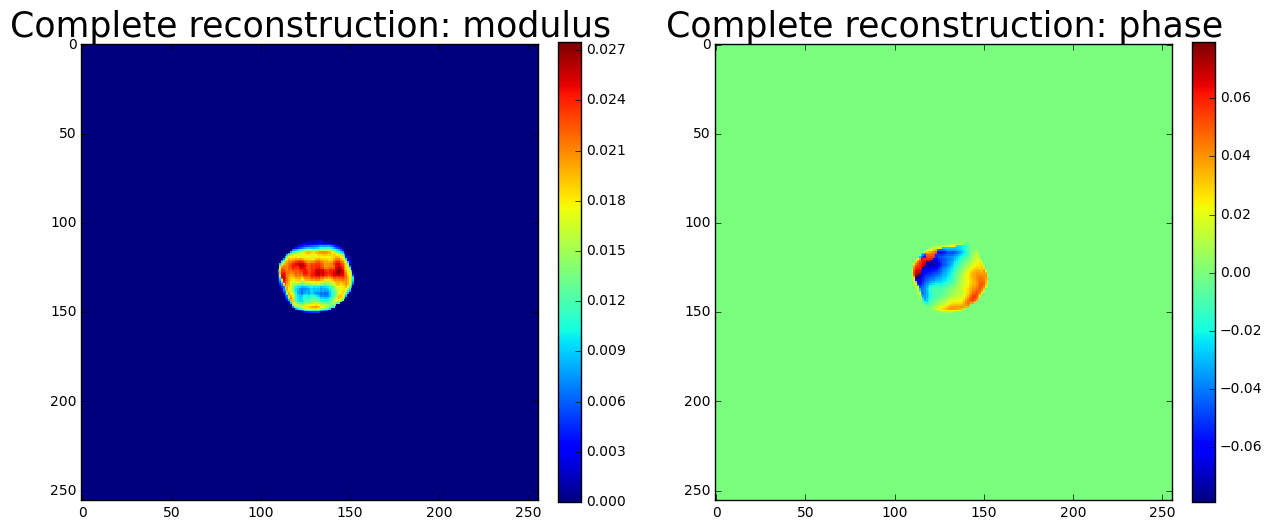

In [19]:
fig = plt.figure( figsize=( 13, 13 ) )

ax1 = plt.subplot2grid( ( 1, 2 ), ( 0, 0 ), colspan=1 )
im1 = ax1.imshow( np.absolute( PhaseRet_BB.Image()[:,:,35] ), interpolation='none' )
ax1.set_title( 'Complete reconstruction: modulus', fontsize=25 )

ax2 = plt.subplot2grid( ( 1, 2 ), ( 0, 1 ), colspan=1 )
im2 = ax2.imshow( np.angle( PhaseRet_BB.Image()[:,:,35] ) * np.absolute( PhaseRet_BB.Image()[:,:,35] ), 
                interpolation='none' )
ax2.set_title( 'Complete reconstruction: phase', fontsize=25 )

fig.colorbar( im1, ax=ax1, fraction=0.046, pad=0.04 )
fig.colorbar( im2, ax=ax2, fraction=0.046, pad=0.04 )
fig.tight_layout()


Visual comparison of computed and measured signal moduli

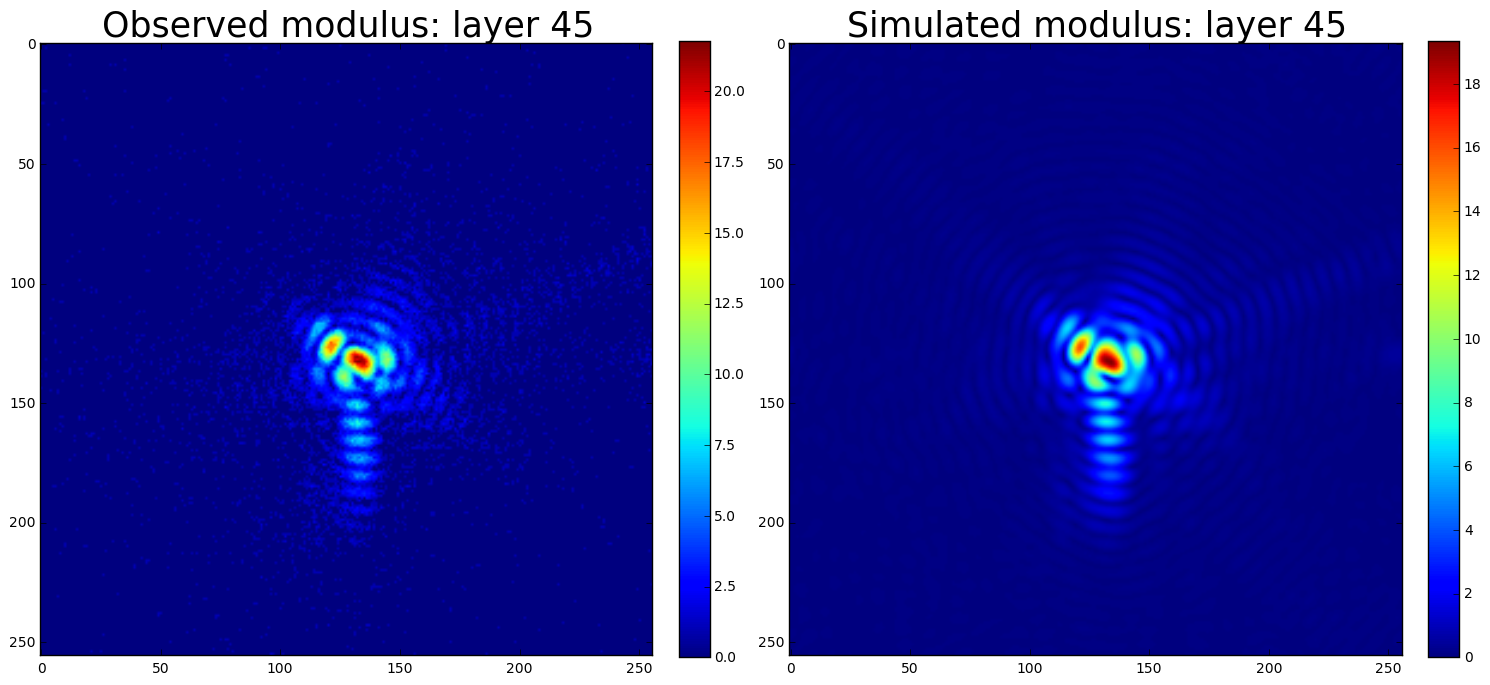

In [23]:
img_final = np.absolute( fftshift( fftn( fftshift( PhaseRet_BB.Image() ) ) ) )
n = 45

fig = plt.figure( figsize=( 15, 15 ) )

ax1 = plt.subplot2grid( ( 1, 2 ), ( 0, 0 ), colspan=1 )
im1 = ax1.imshow( np.absolute( np.sqrt( img )[:,:,n] ) )
ax1.set_title( 'Observed modulus: layer %d' % n, fontsize=25 )

ax2 = plt.subplot2grid( ( 1, 2 ), ( 0, 1 ), colspan=1 )
im2 = ax2.imshow( img_final[:,:,n] )
ax2.set_title( 'Simulated modulus: layer %d' % n, fontsize=25 )

fig.colorbar( im1, ax=ax1, fraction=0.046,  pad=0.04 )
fig.colorbar( im2, ax=ax2, fraction=0.046,  pad=0.04 )
fig.tight_layout()

   - Visualization of the single grain in 3D. 
   - Not yet translated to real-world coordinates.

In [24]:
with open( 'PhaseRet_BB.dill', 'wb' ) as f:
    dill.dump( PhaseRet_BB, f )

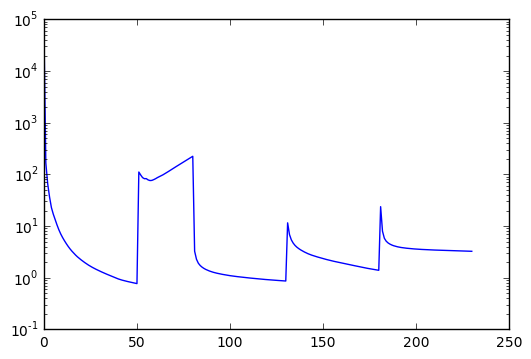

In [25]:
plt.semilogy( PhaseRet_BB.Error() )

In [26]:
MyFinalImg = np.absolute( PhaseRet_BB.Image() )
MyFinalImg = MyFinalImg * ( MyFinalImg > 0.003 ).astype( float )

In [28]:
grid = mlab.pipeline.scalar_field( MyFinalImg )
grid.spacing = [ 
    float( max( MyFinalImg.shape ) ) / float( MyFinalImg.shape[0] ), 
    float( max( MyFinalImg.shape ) ) / float( MyFinalImg.shape[1] ), 
    float( max( MyFinalImg.shape ) ) / float( MyFinalImg.shape[2] )
]

In [30]:
mlab.close()
conts = mlab.pipeline.contour_surface( 
    grid, 
    contours=6, 
    transparent=False
)
# mlab.axes( figure=contours )
conts

# Undersampling a diffraction signal

   - Central problem: what to do with real-space support when undersampling Fourier space?
   - Assumption: Detector pixels coarsen, but detector size does not change.
   - $\Longrightarrow$ step in real space remains the same ($\Delta = \frac{\lambda z}{D}$)

   - Strategy 1: Integrate block of pixels into new pixel
       - Clip support box to maintain size consistency.

In [31]:
display( HTML( """
<img src="images/CoarsenStrategy1.png">
"""))

   - Coarsen in both detector directions, keeping third dimension (# of images) as is.
   - Correspondingly clip support.
   - In the plots below: 
       - X, Y axes are $N$, where new pixel size is $2^N$ times original pixel size.
       - Correspondingly, support box size is $1/2^N$ of the original box.

NameError: name 'X' is not defined

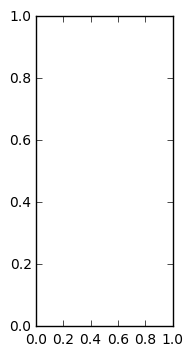

In [32]:
ax1 = plt.subplot2grid( ( 1, 3 ), ( 0, 0 ), colspan=1 )
im1 = ax1.imshow( np.log2( np.array( X ) ).reshape( 6, 6 ), interpolation='none' )

ax2 = plt.subplot2grid( ( 1, 3 ), ( 0, 1 ), colspan=1 )
im2 = ax2.imshow( np.log2( np.array( Y ) ).reshape( 6, 6 ), interpolation='none' )

ax3 = plt.subplot2grid( ( 1, 3 ), ( 0, 2 ), colspan=1 )
im3 = ax3.imshow( np.array( Z ).reshape( 6, 6 ), interpolation='none' )



   - Strategy 2: Smear out values of pixel blocks to their average value.
       - Similar to supersampling larger pixels.
       - Averaging causes loss of information.

In [34]:
display( HTML( """
<img src="images/CoarsenStrategy2.png">
"""))

In [101]:
# img2 = imgp.UndersampleImage( img, step=[ 2, 4, 1 ] )
img2 = imgp.Smear( img, step=[ 2, 2, 1 ] )

The above code acts on a set of diffraction images represented by `img`, and integrates the intensity within a rastered box of size $2^N \times 2^N \times 1$ pixels, where larger $N$ implies greater undersampling. 

We would typically not want to undersample the third dimension since it results from the number of detector images we choose to save at the time of the experiment. In fact, we would like to eventually see the effect of oversampling in this dimension, to possibly make up for inevitable lack of dense sampling in the other two dimensions. Typical in-plane undersampling in a diffraction image is shown below:

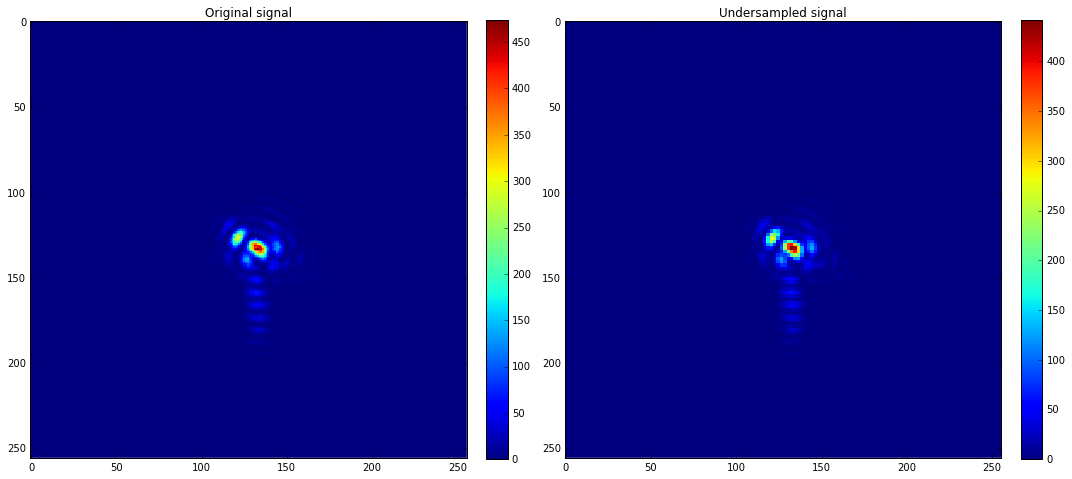

In [102]:
fig = plt.figure( figsize=( 15, 15 ) )
n = 45

ax1 = fig.add_subplot( 121 )
im1 = ax1.imshow( img[:,:,n], interpolation='none' )
ax1.set_title( 'Original signal' )

ax2 = fig.add_subplot( 122 )
im2 = ax2.imshow( img2[:,:,n], interpolation='none' )
ax2.set_title( 'Undersampled signal' )

fig.colorbar( im1, ax=ax1, fraction=0.046, pad=0.04 )
fig.colorbar( im2, ax=ax2, fraction=0.046, pad=0.04  )

fig.tight_layout()

## A more appropriate error metric
Prior to performing phase retrieval on undersampled signals, we would like a more meaningful error metric that we can use to compare across sampling sizes. It is not immediately clear that the one in use earlier is appropriate since it might be too sensitive to the number of pixels. If the Fourier transform of $\rho$ is given by $\tilde{\rho} e^{i\phi}$ then the current error metric is: 
$$
\Delta^2 = \sum_i \left(\tilde{\rho}_{\text{computed}}^{(i)} - \tilde{\rho}_{\text{measured}}^{(i)}\right)^2
$$

where the summation is over all the pixels. We choose a weighted mean squared error metric $\Delta_w^2$, with respect to the observed moduli $\tilde{\rho}^{(i)}$:
$$
\Delta_w^2 = \frac{ \sum_i
    \left(\tilde{\rho})_{\text{computed}}^{(i)} - \tilde{\rho}_{\text{measured}}^{(i)}\right)^2 \times 
    \tilde{\rho}_{\text{measured}}^{(i)}
    }{
      \sum_i \tilde{\rho}_{\text{measured}}^{(i)}  
    }
$$
where a perfect reconstruction would result in $\Delta_w^2 = 0$. This quantity will hereafter be referred to as the the _squared error of reconstruction_.

## How does the numerical definition of the support change with undersampling?
To answer this question, we refer to the Fourier transform relation between a monochromatic scalar field $U(x, y)$ varying in the $XY$ plane propagating in the $z$-direction, and the field value $U(x', y')$ in the $X'Y'$ plane at a
distance $z$ away along the direction of propagation:
$$
U(x', y') \simeq \frac{e^{ikz}}{i\lambda z} e^{-\frac{ik}{2z}\left(x'^2 + y'^2\right)}
\int_{-\infty}^\infty \int_{-\infty}^\infty dxdy~e^{-\frac{ik}{2z}\left(xx' + yy'\right)}
\left[U(x, y)e^{\frac{ik}{2z}\left(x^2+y^2\right)}\right]
$$
where $k = 2\pi / \lambda$. This is the **Fresnel approximation** of scalar diffraction theory. We see that $U(x', y')e^{\frac{ik}{2z}\left(x'^2 + y'^2\right)}$ is essentially the Fourier transform of $U(x, y)e^{\frac{ik}{2z}\left(x^2 + y^2\right)}$ with the spatial frequencies being: $\frac{\pi}{\lambda z}\left(x', y'\right)$.

According to our experiment, we are sampling ( x, y ) with a detector that satisfies : $x = m\Delta, y = n\Delta$. Here $\Delta$ is the pixel pitch. The spatial frequencies in the object plane therefore are:
$$
\left\{m, n\right\} \frac{\Delta}{\lambda z}
$$
therefore the highest spatial frequency is $D/\lambda z$, where $D$ is the size of the detector. Thus, the smallest step _i.e._ the pixel pitch in the object plane is $\lambda z / D$. 

Since by our convention $D$ is constant, the pixel size in the pbject plane does not change. All we need to do is crop the support image to the pixel size of the undersampled dataset. 

In [118]:
# Generating the dimensions of the integration boxes.
# We choose to undersample exponentially, with the 
# desired detector size being:
# ( 256/2^N, 256/2^N )
#  with N = { 0, 1, 2, 3, 4, 5 }.

# XX = np.meshgrid( range( 6 ), range( 6 ) )

# undersample = np.concatenate( 
#     ( 
#         2**XX[0].reshape( -1, 1 ), 
#         2**XX[1].reshape( -1, 1 ), 
#         np.ones( XX[0].shape ).astype( int ).reshape( -1, 1 )
#     ), 
#     axis=1
# )


#  First undersampling square pixels only
undersample = [ [ 2**n, 2**n, 1 ] for n in range( 8 )]

print undersample

[[1, 1, 1], [2, 2, 1], [4, 4, 1], [8, 8, 1], [16, 16, 1], [32, 32, 1], [64, 64, 1], [128, 128, 1]]


In [139]:
# Now defining new solver with the undersampled image and 
# initial support
idx_u = 4
print 'Undersampling ratio = ', undersample[ idx_u ]

img_u = imgp.Smear( img, step=undersample[idx_u] )

# MySupp_u = imgp.UndersampleImage( MySupp, step=undersample[idx_u] )
# MySupp_u = ( MySupp_u > 0. ).astype( float )

MySupp_u = MySupp2
# MySupp_u = MySupp2[ 
#     MySupp.shape[0]/2-img_u.shape[0]/2:MySupp.shape[0]/2+img_u.shape[0]/2, 
#     MySupp.shape[1]/2-img_u.shape[1]/2:MySupp.shape[1]/2+img_u.shape[1]/2, 
#     MySupp.shape[2]/2-img_u.shape[2]/2:MySupp.shape[2]/2+img_u.shape[2]/2
# ]
# print MySupp_u.shape
# print img_u.shape
PhsRet_u = pr.PhaseRetriever( 
    modulus=np.sqrt( img_u ),
    support=MySupp_u, 
    beta=0.95 
)

Undersampling ratio =  [16, 16, 1]


In [140]:
print MySupp_u.shape
print img_u.shape

(256, 256, 70)
(256, 256, 70)


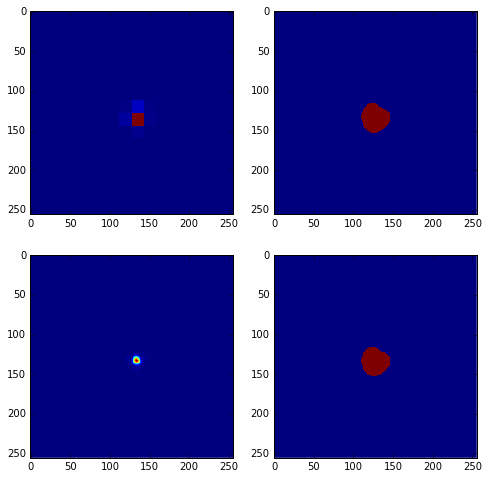

In [141]:
n = 35
fig = plt.figure( figsize=( 8, 8 ) )

ax1 = plt.subplot2grid( ( 2, 2 ), ( 0, 0 ), colspan=1 )
ax1.imshow( np.absolute( img_u[:,:,n] ), interpolation='none' )

ax2 = plt.subplot2grid( ( 2, 2 ), ( 0, 1 ), colspan=1 )
ax2.imshow( np.absolute( MySupp_u[:,:,n] ), interpolation='none' )

ax3 = plt.subplot2grid( ( 2, 2 ), ( 1, 0 ), colspan=1 )
ax3.imshow( np.absolute( img[:,:,n] ), interpolation='none' )

ax4 = plt.subplot2grid( ( 2, 2 ), ( 1, 1 ), colspan=1 )
ax4.imshow( np.absolute( MySupp2[:,:,n] ), interpolation='none' )

In [142]:
# Repating the same set of steps for reconstructing the 
# image from the original data.

PhsRet_u.SolventFlipping( 50 )
PhsRet_u.HybridIO( 30 )
PhsRet_u.SolventFlipping( 50 )
print 'Done initial retrieval.' 

MySupp2_u = imgp.GaussianKernelSupport( 
    np.absolute( PhsRet_u.Image() ), 
    sigma=[ 5./float( n ) for n in undersample[ idx_u ] ], 
    threshold=0.15
)
PhsRet_u.UpdateSupport( MySupp2_u )
print 'Updated support.'

PhsRet_u.SolventFlipping( 200 )
PhsRet_u.HybridIO( 20 )
PhsRet_u.ErrorReduction( 50 )
print 'Done second retrieval.'

MySupp3_u = imgp.GaussianKernelSupport( 
    np.absolute( PhsRet_u.Image() ), 
    sigma=[ 5./float( n ) for n in undersample[ idx_u ] ], 
    threshold=0.15
)
PhsRet_u.UpdateSupport( MySupp3_u )
print 'Updated support.'
PhsRet_u.SolventFlipping( 50 )
PhsRet_u.HybridIO( 5 )
PhsRet_u.ErrorReduction( 50 )
print 'Done third retrieval.'


Done initial retrieval.
Updated support.
Done second retrieval.
Updated support.
Done third retrieval.


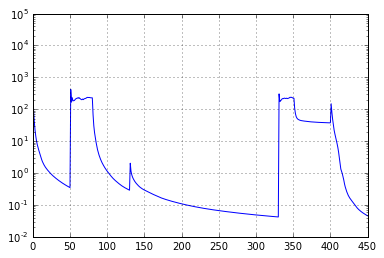

In [144]:
plt.semilogy( PhsRet_u.Error() )
plt.grid( 'on' )

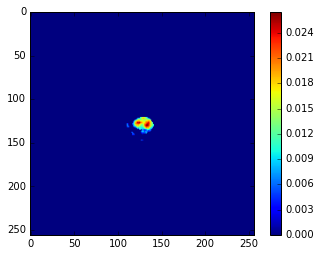

In [148]:
plt.imshow( np.absolute( PhsRet_u.Image()[:,:,35] ) )
plt.colorbar()

In [147]:
PhsRet_u.ErrorReduction( 50 )

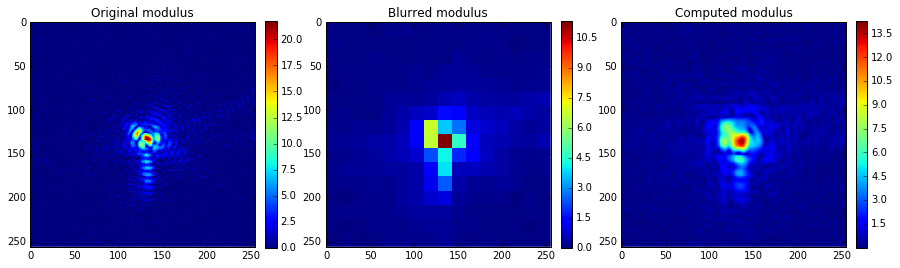

In [149]:
plt.figure( figsize=( 15, 15 ) )
n = 45

ax1 = plt.subplot2grid( ( 1, 3 ), ( 0, 2 ), colspan=1 )
im1 = ax1.imshow( PhsRet_u.Modulus()[:,:,n], interpolation='none' )
ax1.set_title( 'Computed modulus' )

ax2 = plt.subplot2grid( ( 1, 3 ), ( 0, 1 ), colspan=1 )
im2 = ax2.imshow( np.sqrt( np.absolute( img_u ) )[:,:,n], interpolation='none' )
ax2.set_title( 'Blurred modulus' )

ax3 = plt.subplot2grid( ( 1, 3 ), ( 0, 0 ), colspan=1 )
im3 = ax3.imshow( np.sqrt( np.absolute( img ) )[:,:,n], interpolation='none' )
ax3.set_title( 'Original modulus' )


fig.colorbar( im1, ax=ax1, fraction=0.046, pad=0.04 )
fig.colorbar( im2, ax=ax2, fraction=0.046, pad=0.04 )
fig.colorbar( im3, ax=ax3, fraction=0.046, pad=0.04 )

fig.tight_layout()

The plots above show beyond reasonable doubt that we are able to reconstruct under-sampled data effectively. We now push this limit, to see how coarse we can go in the in-plane pixel dimensions. We would like to keep all $70$ images in the direction of the detector step, later to see if fine-graining in this dimension can compensate for the loss of resolution in the other two. The conclusion drawn from this experiment is going to be crucial in establishing feasibility for high-energy coherent diffraction imaging.

We do this by coarse-graining the detector pixels by a factor of $(2^m, 2^n)$ in the in-plane directions and integrating. We plot the final _average_ squared error of reconstruction as a 2-D function of $(2^m, 2^n)$ or equivalently, $(m, n)$. The _average_ will result from repeating the reconstruction for different random image starts.

In [330]:
def SampleError( myimg, mysupport, i=None, seedarray=None ):
    if i!=None and seedarray!=None:
        np.random.seed( seedarray[i] )
    
    PhaseRet_u = pr.PhaseRetriever( modulus=np.sqrt( myimg ), support=mysupport, beta=0.9 )

    # first cycle of retrieval
    PhaseRet_u.SolventFlipping( 50 )
#     print i, ', SF1'
    PhaseRet_u.HybridIO( 30 )
#     print i, ', HIO1'
    PhaseRet_u.SolventFlipping( 50 )
#     print i, ', SF2'

    # shrinkwrap 1
    MySupp_u_2 = imgp.GaussianKernelSupport( 
        PhaseRet_u.Image(), 
        sigma=[ 5., 5., 5. ], 
        threshold=0.15 )
    PhaseRet_u.UpdateSupport( support=MySupp_u_2 )
#     print i, ', SR1'

    # second cycle of retrieval
    PhaseRet_u.SolventFlipping( 50 )
#     print i, ', SF3' 
#     PhaseRet_u.HybridIO( 10 )
    PhaseRet_u.ErrorReduction( 50 )
#     print i, ', ER1'

#     # shrinkwrap 2
#     MySupp_u_3 = imgp.GaussianKernelSupport( 
#         PhaseRet_u.Image(), 
#         sigma=[ 5. / float( p ) for p in n ], 
#         threshold=0.15 )
#     PhaseRet_u.UpdateSupport( support=MySupp_u_3 )

#     # third cycle of phase retrieval
#     PhaseRet_u.SolventFlipping( 50 )
#     PhaseRet_u.HybridIO( 5 )
#     PhaseRet_u.ErrorReduction( 50 )
    return PhaseRet_u.Error()[-1] 

# def SampleError( myimg, mysupport ):
# #     print 'inside function.' 
#     time.sleep( 2 )
#     return np.random.rand()

In [212]:
( stop - start ) / 60.

33.86746323506038

In [332]:
# ErrorLandscape = []
nRepetitions = 7
nJobs = 7


with Parallel( n_jobs=nJobs ) as parallel:
#     for n in tqdm( undersample[:1] ): 
    for n in tqdm( undersample[1:] ):

        MySeedArray = ( 1.e5 * np.random.rand( nRepetitions ) ).astype( int )
        img_u = imgp.Smear( img, step=n )

        MySupp_u_1 = MySupp

        ThisMeasurement = parallel( 
            delayed( SampleError )( 
                myimg=img_u, mysupport=MySupp2, 
                i=i, seedarray=MySeedArray
            ) for i in range( nRepetitions )
        )

        ErrorLandscape += [ [ n, ThisMeasurement ] ]

print ErrorLandscape

  0%|          | 0/7 [00:00<?, ?it/s]Process PoolWorker-248:
Process PoolWorker-252:
Process PoolWorker-254:
Process PoolWorker-249:
Process PoolWorker-250:
Process PoolWorker-253:
Process PoolWorker-251:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/smaddali/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/smaddali/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/smaddali/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/smaddali/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/smaddali/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/smaddali/anaconda2/lib/python2.7/mul

KeyboardInterrupt: 

In [298]:
ErrLandscape = [ [ ErrorLandscape[i][0], [ float( f ) for f in ErrorLandscape[i][1] ] ] for i in range( len( ErrorLandscape ) ) ]

In [315]:
DumpErrors = np.zeros( 
    ( 
        len( ErrLandscape[0][0] ) + len( ErrLandscape[0][1] ), 
        len( ErrLandscape )
    ) 
).T
for i in range( DumpErrors.shape[0] ):
    DumpErrors[ i, 0:3 ] = ErrLandscape[i][0]
    DumpErrors[ i, 3:  ] = ErrLandscape[i][1]
    
np.savez_compressed( 'ErrorLandscape.npz', DumpErrors )

In [335]:
img_u = imgp.Smear( img, step=[ 32, 32, 1] )

SampleError( myimg=img_u, mysupport=MySupp2 )

17.989949476324075

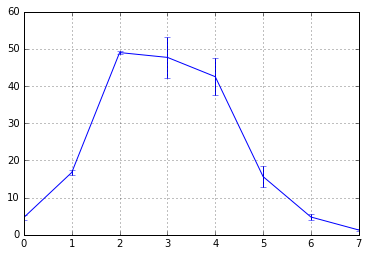

In [326]:
plt.errorbar( np.log2( DumpErrors[:,0] ), 
             DumpErrors[:,3:].mean( axis=1 ), 
             yerr=DumpErrors[:,3:].std( axis=1), 
            fmt='-' )
plt.grid()

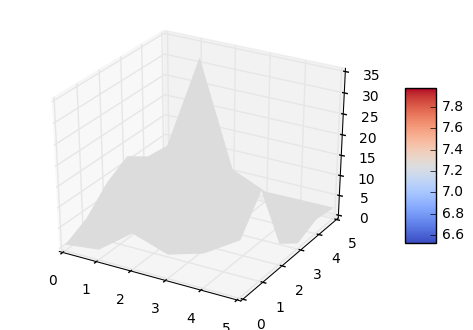

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ax = plt.figure().gca( projection='3d' )
surf = ax.plot_surface( np.log2( X ), np.log2( Y ), Z, cmap=cm.coolwarm, 
                      linewidth=0, antialiased=True )

plt.colorbar( surf, shrink=0.5, aspect=5 )
# plt.show()

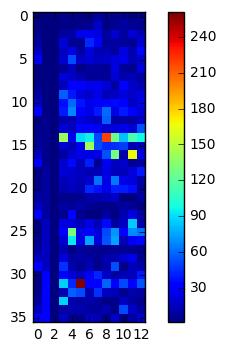

In [7]:
plt.imshow( EL[ 'arr_0' ], interpolation='none'  )
plt.colorbar()

In [123]:
DumpErrors[-1,:]

array([ 32.        ,  32.        ,   1.        ,  15.79292464,
         4.05055087,   2.18645121,  16.71690471,  12.90081154,
         2.29584585,  18.71307359,   2.62791656,   9.50990783,  20.60536004])

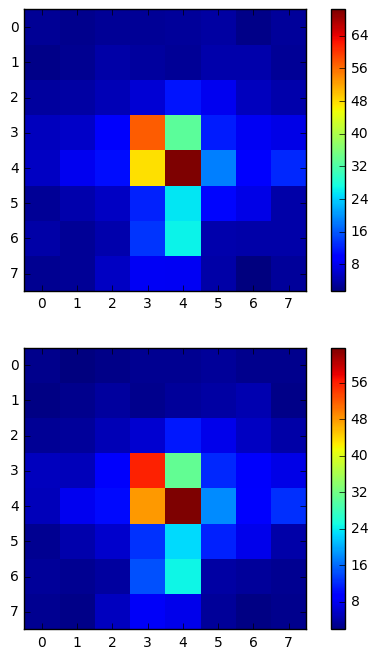

In [126]:
n = 53

plt.figure( figsize=( 8, 8 ) )

ax1 = plt.subplot2grid( ( 2, 1 ), ( 0, 0 ), colspan=1 )
im1 = ax1.imshow( np.sqrt( img_u )[:,:,n], interpolation='none' )

ax2 = plt.subplot2grid( ( 2, 1 ), ( 1, 0 ), colspan=1 )
im2 = ax2.imshow( np.absolute( PhaseRet_u.Modulus() )[:,:,n], interpolation='none' )

fig.colorbar( im1, ax=ax1, fraction=0.046, pad=0.04 )
fig.colorbar( im2, ax=ax2, fraction=0.046, pad=0.04 )

fig.tight_layout()

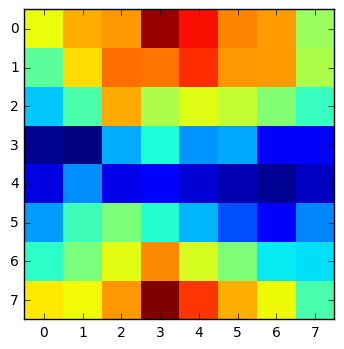

In [147]:
plt.imshow( np.absolute( PhaseRet_u.Image()[:,:,35] ), interpolation='none' )

In [148]:
DumpErrors[:,3:].min( axis=1 )

array([  0.95939452,   1.95347088,   8.18850699,   5.29555016,
         7.84616152,  13.27160509,   3.68416144,   5.91105511,
         8.01761355,  13.46134583,  16.10849315,  21.07744236,
         8.9121888 ,  15.20581735,  26.97970978,  13.41005813,
         8.06579294,   4.62466339,  11.99175422,  10.69221022,
         7.77781038,   1.47682901,   1.50335558,   0.78950251,
         8.43573535,  22.03405826,  13.07817857,   2.01332506,
         4.12227388,   2.9732428 ,   7.75233456,  31.59060143,
         5.71876301,   2.0246679 ,   2.13819261,   2.18645121])